In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive



# Import & Install

In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Thesis/Code')

In [3]:
pip install ta

  Created wheel for ta: filename=ta-0.8.0-py3-none-any.whl size=28895 sha256=27932f324f6744d64d9a2a3ea88c15dbe526391aa040fa31d96d9020a23a5c05
  Stored in directory: /root/.cache/pip/wheels/7e/da/86/65cba22446ae2ef148de2079907264ef27feecfb7f51a45e0d
Successfully built ta


In [4]:
pip install pyts

     |████████████████████████████████| 2.5 MB 10.3 MB/s eta 0:00:01


In [5]:
pip install fracdiff

     |████████████████████████████████| 38.1 MB 330 kB/s 
     |████████████████████████████████| 15.7 MB 51.4 MB/s 
     |████████████████████████████████| 9.8 MB 19.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import financial_eval
import pickle
import tensorflow as tf
import itertools
import random

from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField, MarkovTransitionField
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report, accuracy_score
from sklearn.feature_selection import SelectFromModel
from statsmodels.tsa.stattools import adfuller

from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras import models, layers
from tensorflow.keras.models import load_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from functools import partial

import warnings
warnings.filterwarnings("ignore")

from labeling import *

In [7]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
np.random.RandomState(199)

RandomState(MT19937) at 0x7F5A7DB745A0

# Feature Creation

In [9]:
path = '/content/drive/MyDrive/Thesis/DATA'
data = utils.data_loader(path=(path+"/XSD Historical Data.csv"))

# data = utils.append_var_to_data(data, "copper", (path+"/Copper Futures Historical Data.csv"))
data = utils.append_var_to_data(data, "gold", (path+"/Gold Futures Historical Data.csv"))
# data = utils.append_var_to_data(data, "gas", (path+"/Natural Gas Futures Historical Data.csv"))
data = utils.append_var_to_data(data, "oil", (path+"/Crude Oil WTI Futures Historical Data.csv"))

data = utils.append_var_to_data(data, "s&p500", (path+"/S&P 500 Historical Data.csv"))
# data = utils.append_var_to_data(data, "dow_jones", (path+"/Dow Jones 30 Futures Historical Data.csv"))

data = utils.append_var_to_data(data, "eur_usd", (path+"/EUR_USD Historical Data.csv"))
# data = utils.append_var_to_data(data, "usd_cny", (path+"/USD_CNY Historical Data.csv"))


data.replace(',','', regex=True, inplace=True)
data=data[data.columns].astype(np.float)
data.head()

,close,open,high,low,volume,change%,gold,oil,s&p500,eur_usd
key_0,,,,,,,,,,
2006-02-07,26.82,26.84,26.84,26.64,460000.0,0.41,551.0,63.09,1254.78,1.1974
2006-02-08,27.33,27.05,27.33,27.00,475800.0,1.90,550.1,62.55,1265.65,1.1955
2006-02-09,27.17,27.61,27.66,27.17,164200.0,-0.59,564.5,62.62,1263.78,1.1981
2006-02-10,26.99,27.00,27.00,26.55,763800.0,-0.66,550.2,61.84,1266.99,1.1900
2006-02-13,26.84,26.84,26.84,26.84,150000.0,-0.56,539.0,61.24,1262.86,1.1905


In [10]:
data.drop("change%", axis=1, inplace=True)

In [11]:
from technical_indicators_elisa import *

data = data.loc['2008-10-01':]
indicators = TechnicalIndicator(data)

indicators.get_kst() # KST Oscillator
indicators.get_ppo(col_name="close")
indicators.get_MACD()
indicators.get_rsi()
indicators.get_roc()
indicators.get_williamR()
indicators.get_CCI()

indicators.get_sma(window=5)
indicators.get_sma(window=10)
indicators.get_sma(window=20)

indicators.get_ema(window=5)
indicators.get_ema(window=10)
indicators.get_ema(window=20)

indicators.get_kc(window=10, window_atr=5)
indicators.get_atr(window=10)

In [12]:
data = indicators.df

In [13]:
data.dropna(inplace=True)

# drop inf
print("Total inf values: ", np.isinf(data).values.sum())
drop = data.columns.to_series()[np.isinf(data).any()]
print("Cols with inf: ",drop.values)
data.drop(drop.values, inplace=True, axis=1)
print("Cols with inf dropped")

data = indicators.df
data.head(1)

Total inf values:  0
Cols with inf:  []
Cols with inf dropped


,close,open,high,low,volume,gold,oil,s&p500,eur_usd,kst,ppo,macd,rsi_14,roc_12,wr_14,cci_20,sma_5,sma_10,sma_20,ema_5,ema_10,ema_20,kc_hband_10,kc_lband_10,kc_mband_10,atr_10
key_0,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-11-05,14.95,14.95,14.95,14.95,400.0,741.3,65.3,952.77,1.2952,-373.417346,-2.086043,-0.307475,51.947727,3.317208,-9.440559,62.66089,14.824,14.055,14.1665,14.734997,14.460055,14.556743,15.478324,13.441785,14.460055,0.678675


In [14]:
data.columns

Index(['close', 'open', 'high', 'low', 'volume', 'gold', 'oil', 's&p500',
       'eur_usd', 'kst', 'ppo', 'macd', 'rsi_14', 'roc_12', 'wr_14', 'cci_20',
       'sma_5', 'sma_10', 'sma_20', 'ema_5', 'ema_10', 'ema_20', 'kc_hband_10',
       'kc_lband_10', 'kc_mband_10', 'atr_10'],
      dtype='object')

# Labeling

In [15]:
barriers_df, labels, _ = get_labels_daily(data, (1,1))
data["Y"] = labels
data = data.loc['2008-12-1':]
weights={}
data = data.loc["2009-01-01":"2020-01-01"]
unique, counts = np.unique(data.Y, return_counts=True)

for cl in range(3):
    print("Class ", unique[cl], ": ", counts[cl])
    weights[unique[cl]]=counts[cl]/sum(counts)
print("\n-1.0 = SELL \n0.0 = HOLD \n1.0 = BUY")
data["Y"] = labels

print("NOT FINAL!!")

Class  -1.0 :  692
Class  0.0 :  1360
Class  1.0 :  716

-1.0 = SELL 
0.0 = HOLD 
1.0 = BUY
NOT FINAL!!


# Financial Evaluation of Trading Strategy

In [16]:
financial_eval.financial_performance_model_short(data, data.Y)

Day 1: purchase of 787.63 units for total of 9995 euros

Day 2:
Total sale:945.16 units for total of 12707.4 euros
Closed long position: 787.63 units
New short position: 157.53 units

Day 9:
Short position closed: repurchase of 157.53 shares.
Long position built: 947.99 units. Total value: 10892.38 euros

Day 10:
Total sale:1137.59 units for total of 13634.7 euros
Closed long position: 947.99 units
New short position: 189.6 units

Day 13:
Short position closed: repurchase of 189.6 shares.
Long position built: 1020.85 units. Total value: 11494.81 euros

Day 17:
Total sale:1225.02 units for total of 15344.5 euros
Closed long position: 1020.85 units
New short position: 204.17 units

Day 21:
Short position closed: repurchase of 204.17 shares.
Long position built: 1062.51 units. Total value: 12867.0 euros

Day 25:
Total sale:1275.01 units for total of 17092.88 euros
Closed long position: 1062.51 units
New short position: 212.5 units

Day 34:
Short position closed: repurchase of 212.5 shares

# Train Test Split

In [17]:
train_size = int(0.8*len(data)) # 80%/20% split -> to be discussed 
test_size = len(data) - train_size

X_train, y_train = data[:train_size], data.Y[:train_size]
X_test, y_test = data[train_size:], data.Y[train_size:]

X_train.drop("Y", inplace=True, axis=1)
X_test.drop("Y", inplace=True, axis=1)

# Stationarity

In [18]:
data_copy = data.copy()

In [19]:
# make data staionary
from fracdiff.sklearn import FracdiffStat, Fracdiff
for col in X_train.columns: 
    dickey_fuller = adfuller(X_train[col], maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
    if dickey_fuller[0] > dickey_fuller[4]["5%"]:
        f = FracdiffStat(stattest='ADF', pvalue=0.05)
        print("Differencing for ", col)
        x = X_train[col].values.reshape(-1, 1)
        X_train[col] = f.fit_transform(x).flatten()
        print(f.d_)

        y = X_test[col].values.reshape(-1, 1)
        X_test[col] = f.transform(y).flatten()

Differencing for  close
[0.859375]
Differencing for  open
[0.859375]
Differencing for  high
[0.8671875]
Differencing for  low
[0.8515625]
Differencing for  gold
[0.5859375]
Differencing for  oil
[0.734375]
Differencing for  s&p500
[0.8828125]
Differencing for  eur_usd
[0.6953125]
Differencing for  sma_5
[0.8828125]
Differencing for  sma_10
[0.890625]
Differencing for  sma_20
[0.9296875]
Differencing for  ema_5
[0.8671875]
Differencing for  ema_10
[0.890625]
Differencing for  ema_20
[0.921875]
Differencing for  kc_hband_10
[0.890625]
Differencing for  kc_lband_10
[0.8671875]
Differencing for  kc_mband_10
[0.890625]


In [20]:
X_train, y_train = X_train[1:], y_train[1:]
X_test, y_test = X_test[1:], y_test[1:]

# PCA for Feature Reduction and Multicollinearity Handling 


In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=0, with_std=1)
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [22]:
X_train_std.shape

(2213, 26)

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)#0.9
pca.fit(X_train_std)
print(np.round(pca.explained_variance_ratio_,4))

X_train=pca.transform(X_train_std)
X_test=pca.transform(X_test_std)

[0.5054 0.1584 0.0841 0.0467 0.0368 0.0343 0.0254 0.0234 0.017  0.0165
 0.0142]


In [24]:
X_train.shape

(2213, 11)

# Plot correlation 

Text(0.5, 1.0, 'Correlation Matrix - XSD')

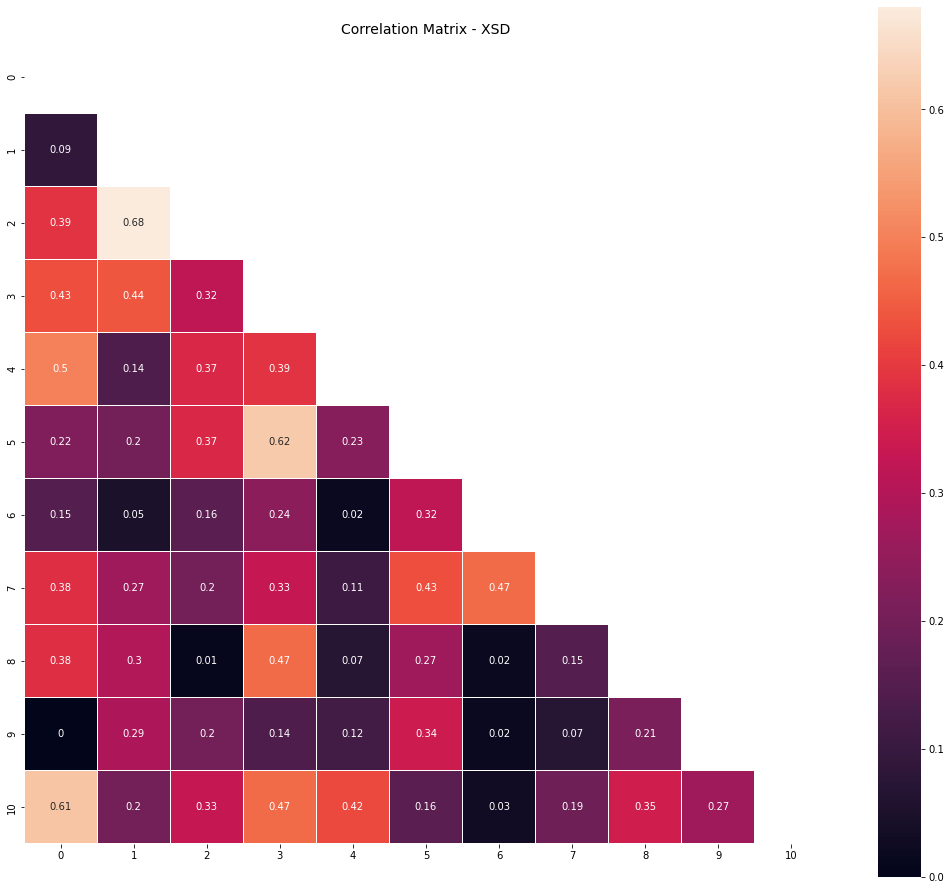

In [ ]:
corr = round(pd.DataFrame(X_test).corr().abs(), 2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 16))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, annot=True, square=True, linewidths=.1).set_title('Correlation Matrix - XSD', fontsize=14)

Text(0.5, 1.0, 'Correlation Matrix - XSD')

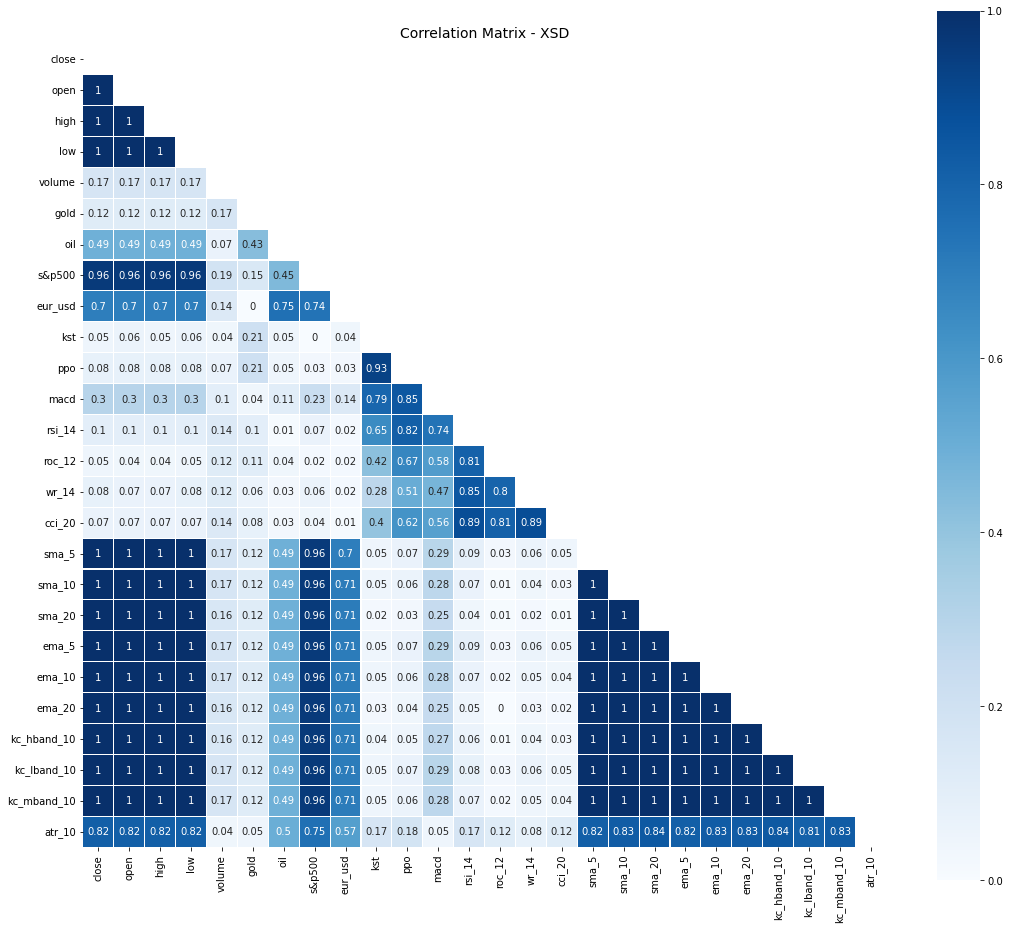

In [28]:
corr = round(pd.DataFrame(data_copy.drop("Y", axis=1)).corr().abs(), 2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 16))
color=sns.color_palette("Blues", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap=color, annot=True, square=True, linewidths=.1).set_title('Correlation Matrix - XSD', fontsize=14)

# Create Images

In [ ]:
# first tur
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
features=[i for i in range(X_train.shape[1])]
X_train=pd.DataFrame(X_train, columns=features)
X_test=pd.DataFrame(X_test, columns=features)

X_train_features = []
X_test_features = []
for i in features:
    X_train_features.append(pd.DataFrame(X_train[i]))
    X_train_features[i].rename(columns={i:0}, inplace=True)
    X_test_features.append(pd.DataFrame(X_test[i]))
    X_test_features[i].rename(columns={i:0}, inplace=True)

window=10
for f in features:    
    for i in range(1, window):
        X_train_features[f][i] = X_train_features[f][0].shift(+i)
        X_test_features[f][i] = X_test_features[f][0].shift(+i)
    
    X_train_features[f].dropna(inplace=True)
    X_test_features[f].dropna(inplace=True)

y_train=y_train[window-1:]
y_test=y_test[window-1:]

In [ ]:
np.array(X_train_features[0]).shape

(2204, 10)

In [ ]:
X_train_features[1]

,0,1,2,3,4,5,6,7,8,9
9,-0.324397,-0.301576,-0.402090,-0.438851,-0.537257,-0.546979,-0.608304,-0.601944,-0.464715,-0.363985
10,-0.256525,-0.324397,-0.301576,-0.402090,-0.438851,-0.537257,-0.546979,-0.608304,-0.601944,-0.464715
11,-0.232641,-0.256525,-0.324397,-0.301576,-0.402090,-0.438851,-0.537257,-0.546979,-0.608304,-0.601944
12,-0.149554,-0.232641,-0.256525,-0.324397,-0.301576,-0.402090,-0.438851,-0.537257,-0.546979,-0.608304
13,-0.109477,-0.149554,-0.232641,-0.256525,-0.324397,-0.301576,-0.402090,-0.438851,-0.537257,-0.546979
...,...,...,...,...,...,...,...,...,...,...
2208,-0.068219,0.014108,0.047789,0.038960,0.132251,0.125731,0.242327,0.321802,0.273650,0.347358
2209,-0.049962,-0.068219,0.014108,0.047789,0.038960,0.132251,0.125731,0.242327,0.321802,0.273650
2210,-0.051629,-0.049962,-0.068219,0.014108,0.047789,0.038960,0.132251,0.125731,0.242327,0.321802
2211,-0.087899,-0.051629,-0.049962,-0.068219,0.014108,0.047789,0.038960,0.132251,0.125731,0.242327


In [ ]:
X_train_gasf = []
X_test_gasf= []

X_train_gadf = []
X_test_gadf= []

X_train_mtf = []
X_test_mtf= []

for f in features:
    gasf = GramianAngularField(image_size=window, sample_range=(-1,1), method='summation')
    X_train_gasf.append(gasf.fit_transform(X_train_features[f]))
    X_test_gasf.append(gasf.transform(X_test_features[f]))
    
    gadf = GramianAngularField(image_size=window, sample_range=(-1,1), method='difference')
    X_train_gadf.append(gadf.fit_transform(X_train_features[f]))
    X_test_gadf.append(gadf.transform(X_test_features[f]))
    
    mtf = MarkovTransitionField(image_size=window, n_bins=3, strategy="quantile") # n_bins=5
    X_train_mtf.append(mtf.fit_transform(X_train_features[f]))
    X_test_mtf.append(mtf.transform(X_test_features[f]))

print(np.array(X_train_gasf).shape) # features, datapoints, window-size, window-size 

a = X_train_gasf[5][4][3][2]

X_train_gasf = np.swapaxes(np.swapaxes(np.swapaxes(np.array(X_train_gasf),0,1), 1,2),2,3)
X_test_gasf = np.swapaxes(np.swapaxes(np.swapaxes(np.array(X_test_gasf),0,1), 1,2),2,3)

b = X_train_gasf[4][3][2][5]

print(a==b)

X_train_gadf = np.swapaxes(np.swapaxes(np.swapaxes(np.array(X_train_gadf),0,1), 1,2),2,3)
X_test_gadf = np.swapaxes(np.swapaxes(np.swapaxes(np.array(X_test_gadf),0,1), 1,2),2,3)

X_train_mtf = np.swapaxes(np.swapaxes(np.swapaxes(np.array(X_train_mtf),0,1), 1,2),2,3)
X_test_mtf = np.swapaxes(np.swapaxes(np.swapaxes(np.array(X_test_mtf),0,1), 1,2),2,3)

(11, 2204, 10, 10)
True


# Save Data and Plot images

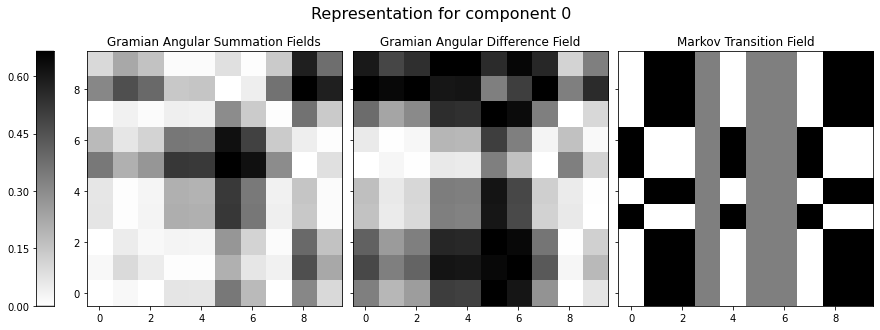

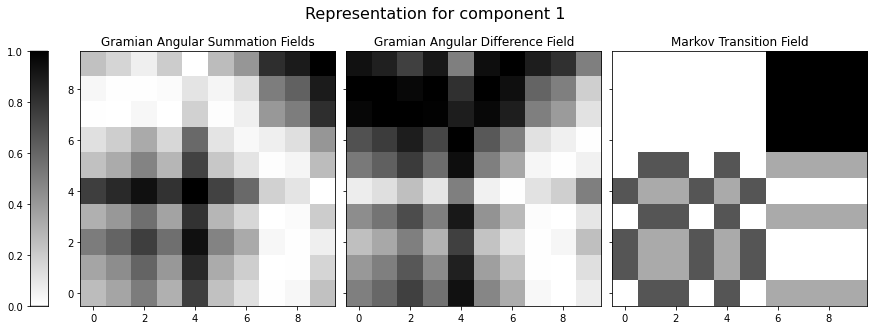

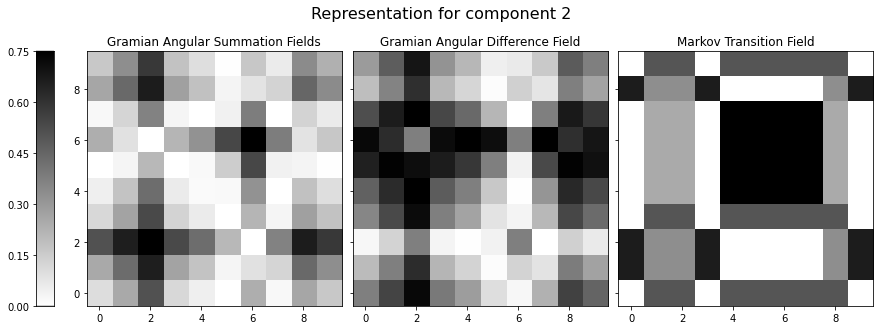

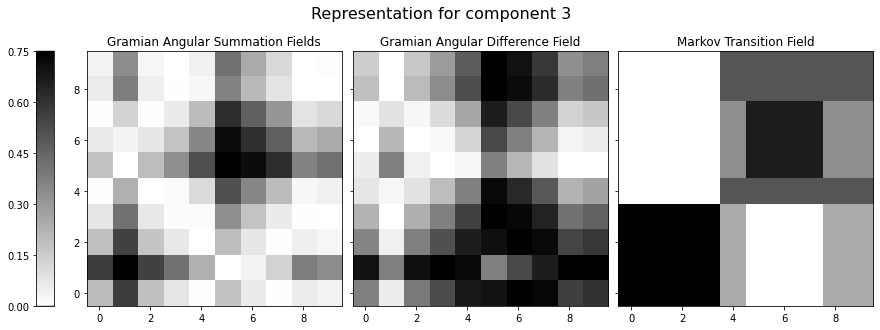

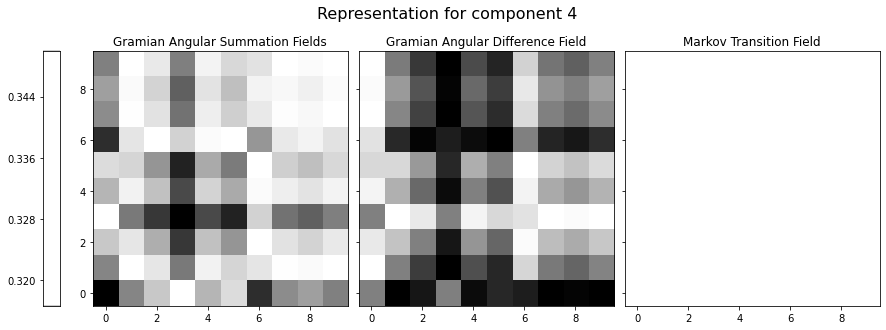

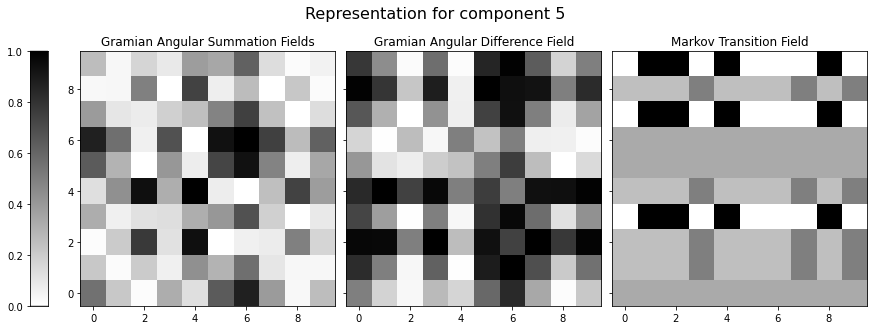

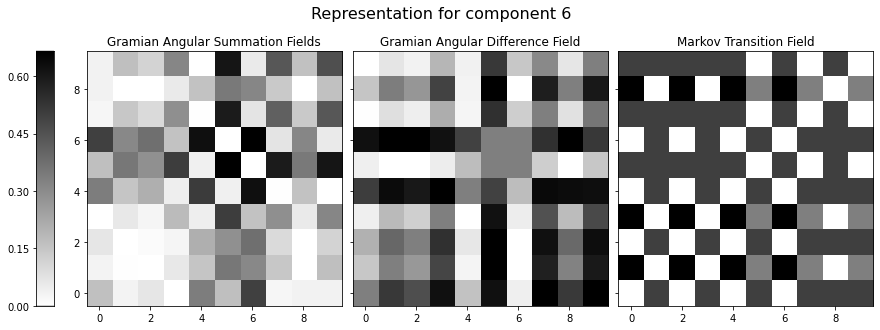

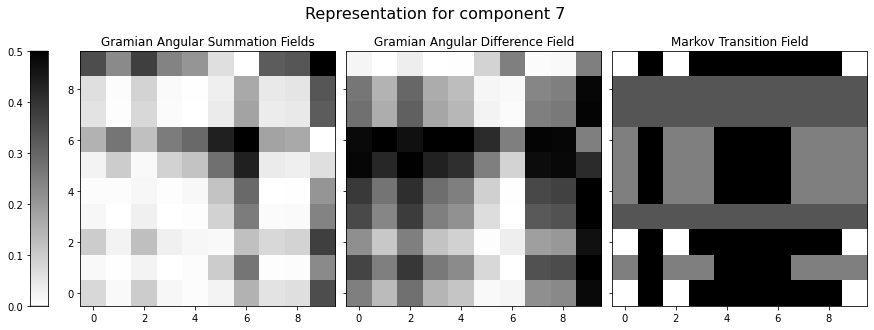

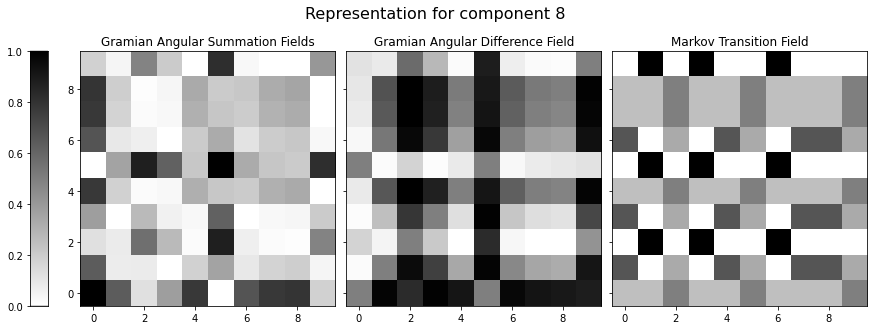

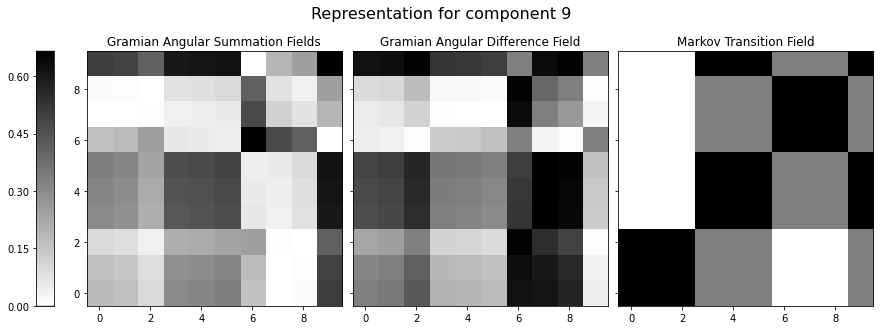

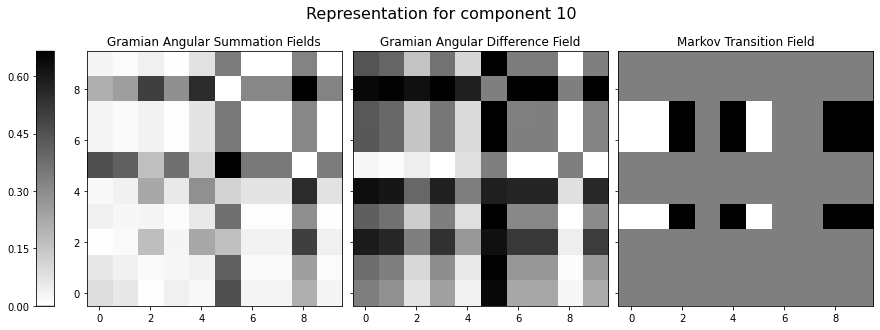

In [ ]:
features=[i for i in range(X_train_gasf.shape[3])]
utils.plot_gaf(gasf=X_train_gasf, gadf=X_train_gadf, mtf=X_train_mtf, datapoint=400, features=features)

# Model

## Parameters & Grid

In [ ]:
y_train = y_train+1 # cnn can't predict negative classes
unique, counts = np.unique(y_train, return_counts=True)

print("Summary Train Set")
for cl in range(3):
    print("Class ", unique[cl], ": ", counts[cl], ", ", round(counts[cl]/sum(counts),4))
print("\n0.0 = SELL \n1.0 = BUY \n2.0 = HOLD")

Summary Train Set
Class  0 :  554 ,  0.2514
Class  1 :  1084 ,  0.4918
Class  2 :  566 ,  0.2568

0.0 = SELL 
1.0 = BUY 
2.0 = HOLD


In [ ]:
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight('balanced',classes=(0,1,2), y = y_train)
weights = {i : weights[i] for i in range(3)}


In [ ]:
y_test = y_test+1 # cnn can't predict negative classes
unique, counts = np.unique(y_test, return_counts=True)

print("Summary Test Set")
for cl in range(3):
    print("Class ", unique[cl], ": ", counts[cl], ", ", round(counts[cl]/sum(counts),4))
    
print("\n0.0 = SELL \n1.0 = BUY \n2.0 = HOLD")

Summary Test Set
Class  0 :  133 ,  0.2445
Class  1 :  269 ,  0.4945
Class  2 :  142 ,  0.261

0.0 = SELL 
1.0 = BUY 
2.0 = HOLD


In [ ]:
def build_model2D_basic(train_X, train_y, val_X, val_Y,
                kernel, activation, padding, pooling, batch_normalization, drop_out, optimizer, learning_rate, batch_size, class_weight, epochs=200, val_data=True): # hyperparameter
    
    DefaultConv2D = partial(layers.Conv2D, kernel_size=kernel, activation=activation, padding=padding)
    
    model = models.Sequential()
    
   
    model.add(DefaultConv2D(filters=64, input_shape=(X_train_gadf[0].shape[0], X_train_gadf[0].shape[1], X_train_gadf[0].shape[2])))
    model.add(DefaultConv2D(filters=128))
    if pooling=="max":
        model.add(layers.MaxPooling2D((2,2)))
    elif pooling=="average":
        model.add(layers.AveragePooling2D((2,2)))

    if batch_normalization==True:
        model.add(layers.BatchNormalization())

    model.add(layers.Flatten())

    # hier nochmal drop_out als "Hyperparameter"?

    model.add(layers.Dense(256, activation=activation))
    #layers.Dense(128, activation="relu"),

    if drop_out != None: 
        model.add(layers.Dropout(drop_out))

    # Output layer
    layers.Dense(3, activation="softmax")

    if optimizer=="adam":
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer =="RMSprop":
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer=="SGD":
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
    
    # es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=10)
    # mcp = ModelCheckpoint("best_model", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
    # es2 = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=10)
  
    if val_data == True: 
        model.fit(train_X, train_y, 
                   validation_data=(val_X, val_y ),
                   epochs=epochs, 
                   batch_size=batch_size,
                   class_weight=class_weight,
                   # callbacks=[es]
                ) 
    else:
        model.fit(train_X, train_y, 
                   epochs=epochs, 
                   batch_size=batch_size,
                   class_weight=class_weight,
                  # callbacks=[es2]
                ) 
   
    return model

In [ ]:
grid2={"kernel": [(3,3),(5,5)],
      "activation":["relu", "sigmoid", "softmax"],
      "padding": ["SAME", "VALID"],
      "pooling": ["max", "average"], 
      "batch_normalization": [True, False],
      "drop_out": [None, 0.25, 0.5],
      "epochs": [5, 10, 25, 50, 75, 100, 150],
      "batch_size": [16, 32, 64],
      "optimizer": ["RMSprop",  "Adam", "SGD"], 
      "learning_rate": [0.0001, 0.001, 0.01], 
       "class_weight": [weights, None]} # weights

keys, values = zip(*grid2.items())
permut_grid = [dict(zip(keys, v)) for v in itertools.product(*values)]

random.seed(12345)#86
random.shuffle(permut_grid)

In [ ]:
val_iterations=3
validation_size=len(X_train_gadf)*0.2
train_split_start = np.array([0, validation_size, validation_size*2]).astype("int")
train_split_end = np.array([-3*validation_size, -2*validation_size, -1*validation_size]).astype("int") # also val split_start 
val_split_end = np.array([-2*validation_size, -1*validation_size, -1]).astype("int")

## GADF

### Train

In [ ]:
params={}
history_gadf = {}
for m in range(200):
    print(m)
    print("\nNew Model with Params", permut_grid[m] )
    params[m]=permut_grid[m] 
    cv_history= []
    for cv in range(val_iterations):
        train_X = X_train_gadf[train_split_start[cv]:train_split_end[cv]]
        train_y = y_train[train_split_start[cv]:train_split_end[cv]]
        val_X = X_train_gadf[train_split_end[cv]:val_split_end[cv]]
        val_y = y_train[train_split_end[cv]:val_split_end[cv]]
        
        model_ =  build_model2D_basic(train_X, train_y, val_X, val_y,
                                kernel=permut_grid[m]["kernel"],
                                activation=permut_grid[m]["activation"],
                                padding=permut_grid[m]["padding"], 
                                pooling=permut_grid[m]["pooling"], 
                                batch_normalization=permut_grid[m]["batch_normalization"], 
                                drop_out=permut_grid[m]["drop_out"],
                                optimizer=permut_grid[m]["optimizer"],
                                learning_rate=permut_grid[m]["learning_rate"], 
                                epochs=permut_grid[m]["epochs"],  
                                batch_size=permut_grid[m]["batch_size"],
                                class_weight=permut_grid[m]["class_weight"], 
                                )        
        cv_history.append(model_.history.history)
    history_gadf[m]=cv_history

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
14/14 [==============================] - 0s 7ms/step - loss: 1.5340 - accuracy: 0.7460 - val_loss: 5.1258 - val_accuracy: 0.4467
Epoch 31/75
14/14 [==============================] - 0s 6ms/step - loss: 1.4801 - accuracy: 0.7517 - val_loss: 5.4277 - val_accuracy: 0.4785
Epoch 32/75
14/14 [==============================] - 0s 6ms/step - loss: 1.5492 - accuracy: 0.7336 - val_loss: 5.5315 - val_accuracy: 0.4603
Epoch 33/75
14/14 [==============================] - 0s 6ms/step - loss: 1.4707 - accuracy: 0.7426 - val_loss: 5.6396 - val_accuracy: 0.4467
Epoch 34/75
14/14 [==============================] - 0s 6ms/step - loss: 1.4599 - accuracy: 0.7483 - val_loss: 5.4927 - val_accuracy: 0.4671
Epoch 35/75
14/14 [==============================] - 0s 7ms/step - loss: 1.5351 - accuracy: 0.7336 - val_loss: 5.7366 - val_accuracy: 0.4444
Epoch 36/75
14/14 [==============================] - 0s 7ms/step - loss: 1.6070 - accuracy: 0.7268 

In [ ]:
text_file = open("/content/drive/MyDrive/Thesis/results/GADF_results_XSD_GADF.txt", "w")
text_file.write(
    """
    History: {}, 
    Grid Params: {} 
    """.format(history_gadf, params))
text_file.close()

In [ ]:
avg_cv_results_gadf = {}
for i in history_gadf.keys():
    loss = np.array([history_gadf[i][0]["loss"], history_gadf[i][1]["loss"], history_gadf[i][2]["loss"]]).mean(axis=0)
    accuracy = np.array([history_gadf[i][0]["accuracy"], history_gadf[i][1]["accuracy"], history_gadf[i][2]["accuracy"]]).mean(axis=0)
    val_loss = np.array([history_gadf[i][0]["val_loss"], history_gadf[i][1]["val_loss"], history_gadf[i][2]["val_loss"]]).mean(axis=0)
    val_accuracy = np.array([history_gadf[i][0]["val_accuracy"], history_gadf[i][1]["val_accuracy"], history_gadf[i][2]["val_accuracy"]]).mean(axis=0)
    avg_cv_results_gadf[i] = {"loss": loss,
                        "accuracy":accuracy,
                        "val_loss": val_loss, 
                        "val_accuracy": val_accuracy}

In [ ]:
best_val_acc_gadf = 0
best_params_gadf = 0
best_key_gadf = 0

for m in avg_cv_results_gadf.keys():
    if avg_cv_results_gadf[m]["val_accuracy"][-1] > best_val_acc_gadf:
        best_val_acc_gadf=avg_cv_results_gadf[m]["val_accuracy"][-1]
        best_params_gadf=params[m]
        best_key_gadf = m

### Results

In [ ]:
best_key_gadf

2

In [ ]:
best_params_gadf

{'activation': 'softmax',
 'batch_normalization': True,
 'batch_size': 32,
 'class_weight': None,
 'drop_out': 0.5,
 'epochs': 50,
 'kernel': (3, 3),
 'learning_rate': 0.001,
 'optimizer': 'Adam',
 'padding': 'VALID',
 'pooling': 'average'}

In [ ]:
best_val_acc_gadf # 0.5140677392482758

0.5163353085517883

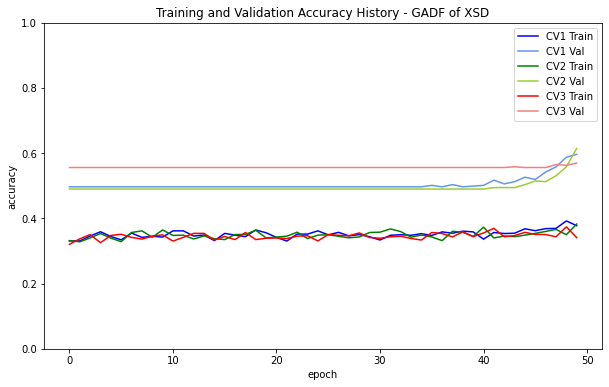

In [ ]:
# plot best history 
x=np.arange(best_params_gadf["epochs"])
plt.figure(figsize=(10, 6))

plt.plot(x, history_gadf[best_key_gadf][0]["accuracy"], color="b")
plt.plot(x, history_gadf[best_key_gadf][0]["val_accuracy"], color="cornflowerblue")
plt.plot(x, history_gadf[best_key_gadf][1]["accuracy"], color="g")
plt.plot(x, history_gadf[best_key_gadf][1]["val_accuracy"], "yellowgreen")
plt.plot(x, history_gadf[best_key_gadf][2]["accuracy"], color="r")
plt.plot(x, history_gadf[best_key_gadf][2]["val_accuracy"], color="lightcoral")
plt.legend(["CV1 Train", "CV1 Val", "CV2 Train", "CV2 Val", "CV3 Train", "CV3 Val"], loc="upper right")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Training and Validation Accuracy History - GADF of XSD")
plt.ylim(0,1)
plt.show()

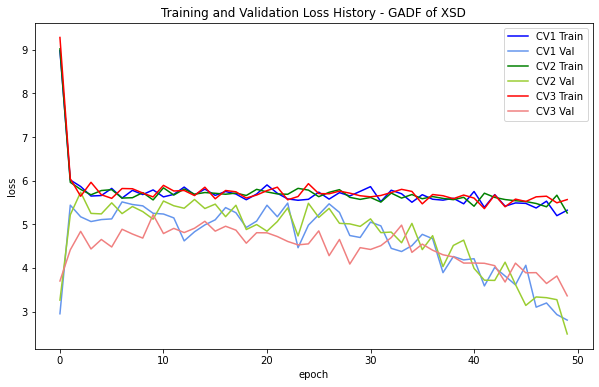

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(x, history_gadf[best_key_gadf][0]["loss"], color="b")
plt.plot(x, history_gadf[best_key_gadf][0]["val_loss"], color="cornflowerblue")
plt.plot(x, history_gadf[best_key_gadf][1]["loss"], color="g")
plt.plot(x, history_gadf[best_key_gadf][1]["val_loss"], "yellowgreen")
plt.plot(x, history_gadf[best_key_gadf][2]["loss"], color="r")
plt.plot(x, history_gadf[best_key_gadf][2]["val_loss"], color="lightcoral")
plt.legend(["CV1 Train", "CV1 Val", "CV2 Train", "CV2 Val", "CV3 Train", "CV3 Val"], loc="upper right")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training and Validation Loss History - GADF of XSD")
plt.show()

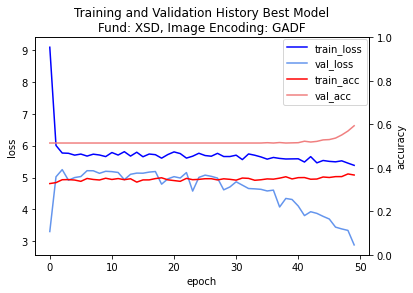

<Figure size 432x288 with 0 Axes>

In [ ]:
fig,ax = plt.subplots()
ax.plot(x, avg_cv_results_gadf[best_key_gadf]["loss"], color="b", label="train_loss")
ax.plot(x, avg_cv_results_gadf[best_key_gadf]["val_loss"], color="cornflowerblue", label="val_loss")# set x-axis label
ax.set_xlabel("epoch",fontsize=10)
ax.set_ylabel("loss",fontsize=10)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(x, avg_cv_results_gadf[best_key_gadf]["accuracy"], color="r", label="train_acc")
ax2.plot(x, avg_cv_results_gadf[best_key_gadf]["val_accuracy"], color="lightcoral", label="val_acc")
ax2.set_ylim((0,1))
ax2.set_ylabel("accuracy",fontsize=10)
fig.legend(loc='upper right', bbox_to_anchor=(0.36, 0.4, 0.5, 0.5))
plt.title("Training and Validation History Best Model\nFund: XSD, Image Encoding: GADF")
plt.show()

plt.savefig("/content/drive/MyDrive/Thesis/results/history_xsd_gadf")

In [ ]:
val_X=1
val_y=2

best_model_gadf =  build_model2D_basic(X_train_gadf, y_train, val_X, val_y,
                        kernel=best_params_gadf["kernel"],
                        activation=best_params_gadf["activation"],
                        padding=best_params_gadf["padding"], 
                        pooling=best_params_gadf["pooling"], 
                        batch_normalization=best_params_gadf["batch_normalization"], 
                        drop_out=best_params_gadf["drop_out"],
                        optimizer=best_params_gadf["optimizer"],
                        learning_rate=best_params_gadf["learning_rate"], 
                        epochs=best_params_gadf["epochs"],  
                        batch_size=best_params_gadf["batch_size"], 
                        class_weight=best_params_gadf["class_weight"],
                        val_data=False)

In [ ]:
tf.keras.models.save_model(best_model_gadf, filepath="/content/drive/MyDrive/Thesis/results/BESTMODEL_XSD_GADF")  
# best_model_gadf = load_model("/content/drive/MyDrive/Thesis/results/BESTMODEL_XSD_GADF")

In [ ]:
_, train_acc_ = best_model_gadf.evaluate(X_train_gadf, y_train, verbose=0)
_, test_acc = best_model_gadf.evaluate(X_test_gadf, y_test, verbose=0, )

print("train_acc",round(train_acc_,4))
print("test_acc",round(test_acc,4))

predict_train = best_model_gadf.predict(X_train_gadf)
predictions_train=np.argmax(predict_train,axis=1)

predict_test = best_model_gadf.predict(X_test_gadf)
predictions_test=np.argmax(predict_test,axis=1)

print("\nMacro Average Train",  round(f1_score(y_train,predictions_train, average="macro"),4))
print("Macro Average Test",  round(f1_score(y_test,predictions_test, average="macro"),4))

print("\nWeighted Average Train",  round(f1_score(y_train,predictions_train, average="weighted"),4))
print("Weighted Average Test",  round(f1_score(y_test,predictions_test, average="weighted"),4))

print("\nClassification Report Train Set")
print(classification_report(y_train, predictions_train, digits=4))

print("\nClassification Report Test Set")
print(classification_report(y_test, predictions_test, digits=4))

train_acc 0.5776
test_acc 0.5018

Macro Average Train 0.437
Macro Average Test 0.2843

Weighted Average Train 0.5011
Weighted Average Test 0.3782

Classification Report Train Set
              precision    recall  f1-score   support

           0     0.7748    0.1552    0.2586       554
           1     0.5525    0.9760    0.7056      1084
           2     0.7247    0.2279    0.3468       566

    accuracy                         0.5776      2204
   macro avg     0.6840    0.4531    0.4370      2204
weighted avg     0.6526    0.5776    0.5011      2204


Classification Report Test Set
              precision    recall  f1-score   support

           0     0.1765    0.0226    0.0400       133
           1     0.5139    0.9591    0.6693       269
           2     0.4800    0.0845    0.1437       142

    accuracy                         0.5018       544
   macro avg     0.3901    0.3554    0.2843       544
weighted avg     0.4226    0.5018    0.3782       544



In [ ]:
df_confusion = pd.crosstab(y_test, predictions_test, colnames=["prediction"], rownames=["true value"])
print(df_confusion)

prediction  0    1   2
true value            
0           3  121   9
1           7  258   4
2           7  123  12


In [ ]:
from financial_eval import financial_performance_model_short

predictions_train=predictions_train-1
financial_performance_model_short(data_copy[10:len(predictions_train)+10], predictions_train)

Day 23: purchase of 872.16 units for total of 9995 euros

Day 77:
Total sale:1046.59 units for total of 15788.04 euros
Closed long position: 872.16 units
New short position: 174.43 units

Day 108:
Short position closed: repurchase of 174.43 shares.
Long position built: 794.45 units. Total value: 12941.58 euros

Day 117:
Total sale:953.34 units for total of 15420.04 euros
Closed long position: 794.45 units
New short position: 158.89 units

Day 136:
Short position closed: repurchase of 158.89 shares.
Long position built: 633.66 units. Total value: 12324.63 euros

Day 137:
Total sale:760.39 units for total of 14738.96 euros
Closed long position: 633.66 units
New short position: 126.73 units

Day 139:
Short position closed: repurchase of 126.73 shares.
Long position built: 652.43 units. Total value: 12337.5 euros

Day 141:
Total sale:782.92 units for total of 14760.87 euros
Closed long position: 652.43 units
New short position: 130.49 units

Day 179:
Short position closed: repurchase of 13

In [ ]:
predictions_test=predictions_test-1
financial_performance_model_short(data_copy[-len(predictions_test):], predictions_test)

Day 24: purchase of 146.02 units for total of 9995 euros

Day 159:
Total sale:175.22 units for total of 13273.17 euros
Closed long position: 146.02 units
New short position: 29.2 units

Day 182:
Short position closed: repurchase of 29.2 shares.
Long position built: 148.13 units. Total value: 11083.43 euros

Day 185:
Total sale:177.76 units for total of 13177.68 euros
Closed long position: 148.13 units
New short position: 29.63 units

Day 227:
Short position closed: repurchase of 29.63 shares.
Long position built: 145.1 units. Total value: 10938.88 euros

Day 330:
Total sale:174.12 units for total of 13675.61 euros
Closed long position: 145.1 units
New short position: 29.02 units

Day 337:
Short position closed: repurchase of 29.02 shares.
Long position built: 149.98 units. Total value: 11454.35 euros

Day 369:
Total sale:179.98 units for total of 16033.02 euros
Closed long position: 149.98 units
New short position: 30.0 units

Day 378:
Short position closed: repurchase of 30.0 shares.


## GASF 


### Train

In [ ]:
random.seed(22)
random.shuffle(permut_grid)
params={}
history_gasf = {}
for m in range(150):
    print(m)
    print("\nNew Model with Params", permut_grid[m] )
    cv_history= []
    params[m]=permut_grid[m] 
    for cv in range(val_iterations):
        train_X = X_train_gasf[train_split_start[cv]:train_split_end[cv]]
        train_y = y_train[train_split_start[cv]:train_split_end[cv]]
        val_X = X_train_gasf[train_split_end[cv]:val_split_end[cv]]
        val_y = y_train[train_split_end[cv]:val_split_end[cv]]
        
        model_ =  build_model2D_basic(train_X, train_y, val_X, val_y,
                                kernel=permut_grid[m]["kernel"],
                                activation=permut_grid[m]["activation"],
                                padding=permut_grid[m]["padding"], 
                                pooling=permut_grid[m]["pooling"], 
                                batch_normalization=permut_grid[m]["batch_normalization"], 
                                drop_out=permut_grid[m]["drop_out"],
                                optimizer=permut_grid[m]["optimizer"],
                                learning_rate=permut_grid[m]["learning_rate"], 
                                epochs=permut_grid[m]["epochs"],  
                                batch_size=permut_grid[m]["batch_size"], 
                                class_weight=permut_grid[m]["class_weight"],
                            )        
        cv_history.append(model_.history.history)
    history_gasf[m]=cv_history

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Epoch 14/50
56/56 [==============================] - 0s 6ms/step - loss: 8.0105 - accuracy: 0.2812 - val_loss: 5.3396 - val_accuracy: 0.2426
Epoch 15/50
56/56 [==============================] - 0s 6ms/step - loss: 8.0257 - accuracy: 0.2857 - val_loss: 5.3252 - val_accuracy: 0.2426
Epoch 16/50
56/56 [==============================] - 0s 6ms/step - loss: 7.7606 - accuracy: 0.2834 - val_loss: 5.3099 - val_accuracy: 0.2426
Epoch 17/50
56/56 [==============================] - 0s 6ms/step - loss: 7.9793 - accuracy: 0.2698 - val_loss: 5.2953 - val_accuracy: 0.2426
Epoch 18/50
56/56 [==============================] - 0s 6ms/step - loss: 7.8683 - accuracy: 0.2857 - val_loss: 5.2806 - val_accuracy: 0.2426
Epoch 19/50
56/56 [==============================] - 0s 6ms/step - loss: 7.9875 - accuracy: 0.2642 - val_loss: 5.2659 - val_accuracy: 0.2426
Epoch 20/50
56/56 [==============================] - 0s 6ms/step - loss: 8.0110 - accur

In [ ]:
text_file = open("/content/drive/MyDrive/Thesis/results/GASF_results_XSD.txt", "w")
text_file.write(
    """
    History: {}, 
    Grid Params: {} 
    """.format(history_gasf, params))
text_file.close()

In [ ]:
avg_cv_results_gasf = {}
for i in history_gasf.keys():
    loss = np.array([history_gasf[i][0]["loss"], history_gasf[i][1]["loss"], history_gasf[i][2]["loss"]]).mean(axis=0)
    accuracy = np.array([history_gasf[i][0]["accuracy"], history_gasf[i][1]["accuracy"], history_gasf[i][2]["accuracy"]]).mean(axis=0)
    val_loss = np.array([history_gasf[i][0]["val_loss"], history_gasf[i][1]["val_loss"], history_gasf[i][2]["val_loss"]]).mean(axis=0)
    val_accuracy = np.array([history_gasf[i][0]["val_accuracy"], history_gasf[i][1]["val_accuracy"], history_gasf[i][2]["val_accuracy"]]).mean(axis=0)
    avg_cv_results_gasf[i] = {"loss": loss,
                        "accuracy":accuracy,
                        "val_loss": val_loss, 
                        "val_accuracy": val_accuracy}

In [ ]:
best_val_acc_gasf = 0
best_params_gasf = 0
best_key_gasf = 0

for m in avg_cv_results_gasf.keys():
    if avg_cv_results_gasf[m]["val_accuracy"][-1] > best_val_acc_gasf and avg_cv_results_gasf[m]["val_accuracy"][-1] != 0.5140677392482758:
        best_val_acc_gasf=avg_cv_results_gasf[m]["val_accuracy"][-1]
        best_params_gasf=params[m]
        best_key_gasf = m

### Results

In [ ]:
best_params_gasf

{'activation': 'sigmoid',
 'batch_normalization': False,
 'batch_size': 64,
 'class_weight': None,
 'drop_out': None,
 'epochs': 75,
 'kernel': (3, 3),
 'learning_rate': 0.0001,
 'optimizer': 'RMSprop',
 'padding': 'SAME',
 'pooling': 'average'}

In [ ]:
best_val_acc_gasf

0.5057533085346222

In [ ]:
best_key_gasf

62

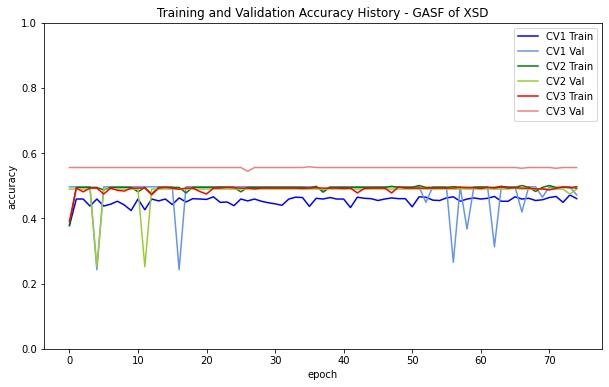

In [ ]:
# plot best history 
x=np.arange(best_params_gasf["epochs"])
plt.figure(figsize=(10, 6))

plt.plot(x, history_gasf[best_key_gasf][0]["accuracy"], color="b")
plt.plot(x, history_gasf[best_key_gasf][0]["val_accuracy"], color="cornflowerblue")
plt.plot(x, history_gasf[best_key_gasf][1]["accuracy"], color="g")
plt.plot(x, history_gasf[best_key_gasf][1]["val_accuracy"], "yellowgreen")
plt.plot(x, history_gasf[best_key_gasf][2]["accuracy"], color="r")
plt.plot(x, history_gasf[best_key_gasf][2]["val_accuracy"], color="lightcoral")
plt.legend(["CV1 Train", "CV1 Val", "CV2 Train", "CV2 Val", "CV3 Train", "CV3 Val"], loc="upper right")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Training and Validation Accuracy History - GASF of XSD")
plt.ylim(0,1)
plt.show()

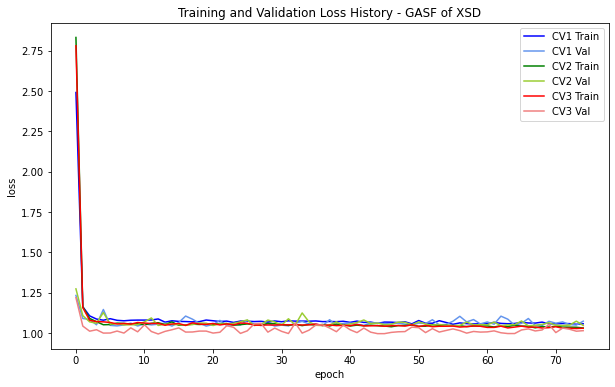

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(x, history_gasf[best_key_gasf][0]["loss"], color="b")
plt.plot(x, history_gasf[best_key_gasf][0]["val_loss"], color="cornflowerblue")
plt.plot(x, history_gasf[best_key_gasf][1]["loss"], color="g")
plt.plot(x, history_gasf[best_key_gasf][1]["val_loss"], "yellowgreen")
plt.plot(x, history_gasf[best_key_gasf][2]["loss"], color="r")
plt.plot(x, history_gasf[best_key_gasf][2]["val_loss"], color="lightcoral")
plt.legend(["CV1 Train", "CV1 Val", "CV2 Train", "CV2 Val", "CV3 Train", "CV3 Val"], loc="upper right")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training and Validation Loss History - GASF of XSD")
plt.show()

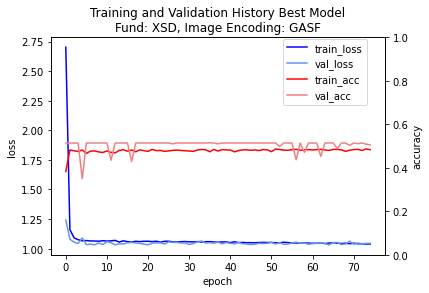

<Figure size 432x288 with 0 Axes>

In [ ]:
fig,ax = plt.subplots()
ax.plot(x, avg_cv_results_gasf[best_key_gasf]["loss"], color="b", label="train_loss")
ax.plot(x, avg_cv_results_gasf[best_key_gasf]["val_loss"], color="cornflowerblue", label="val_loss")# set x-axis label
ax.set_xlabel("epoch",fontsize=10)
ax.set_ylabel("loss",fontsize=10)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(x, avg_cv_results_gasf[best_key_gasf]["accuracy"], color="r", label="train_acc")
ax2.plot(x, avg_cv_results_gasf[best_key_gasf]["val_accuracy"], color="lightcoral", label="val_acc")
ax2.set_ylim((0,1))
ax2.set_ylabel("accuracy",fontsize=10)
fig.legend(loc='upper right', bbox_to_anchor=(0.36, 0.4, 0.5, 0.5))
plt.title("Training and Validation History Best Model\nFund: XSD, Image Encoding: GASF")
plt.show()

plt.savefig("/content/drive/MyDrive/Thesis/results/history_xsd_gasf")

In [ ]:
val_X=1
val_y=2

best_model_gasf = build_model2D_basic(X_train_gasf, y_train, val_X, val_y,
                          kernel=best_params_gasf["kernel"],
                          activation=best_params_gasf["activation"],
                          padding=best_params_gasf["padding"], 
                          pooling=best_params_gasf["pooling"], 
                          batch_normalization=best_params_gasf["batch_normalization"], 
                          drop_out=best_params_gasf["drop_out"],
                          optimizer=best_params_gasf["optimizer"],
                          learning_rate=best_params_gasf["learning_rate"], 
                          epochs=24, #best_params_gasf["epochs"],  
                          batch_size=best_params_gasf["batch_size"], 
                          class_weight=best_params_gasf["class_weight"],
                          val_data=False)

In [ ]:
tf.keras.models.save_model(best_model_gasf, filepath="/content/drive/MyDrive/Thesis/results/BESTMODEL_XSD_GASF")  
# best_model_gasf = load_model("/content/drive/MyDrive/Thesis/results/BESTMODEL_XSD_GASF")

In [ ]:
_, train_acc_ = best_model_gasf.evaluate(X_train_gasf, y_train, verbose=0)
_, test_acc = best_model_gasf.evaluate(X_test_gasf, y_test, verbose=0)

print("train_acc",train_acc_)
print("\ntest_acc",test_acc)

predict_train = best_model_gasf.predict(X_train_gasf)
predictions_train=np.argmax(predict_train,axis=1)

predict_test = best_model_gasf.predict(X_test_gasf)
predictions_test=np.argmax(predict_test,axis=1)

print("\nMacro Average Train",  round(f1_score(y_train,predictions_train, average="macro"),4))
print("Macro Average Test",  round(f1_score(y_test,predictions_test, average="macro"),4))

print("\nWeighted Average Train",  round(f1_score(y_train,predictions_train, average="weighted"),4))
print("Weighted Average Test",  round(f1_score(y_test,predictions_test, average="weighted"),4))

print("\nClassification Report Train Set")
print(classification_report(y_train, predictions_train, digits=4))

print("\nClassification Report Test Set")
print(classification_report(y_test, predictions_test, digits=4))

train_acc 0.4972776770591736

test_acc 0.44117647409439087

Macro Average Train 0.3973
Macro Average Test 0.3375

Weighted Average Train 0.4554
Weighted Average Test 0.399

Classification Report Train Set
              precision    recall  f1-score   support

           0     0.3975    0.1751    0.2431       554
           1     0.5406    0.7869    0.6409      1084
           2     0.3822    0.2580    0.3080       566

    accuracy                         0.4973      2204
   macro avg     0.4401    0.4066    0.3973      2204
weighted avg     0.4639    0.4973    0.4554      2204


Classification Report Test Set
              precision    recall  f1-score   support

           0     0.3291    0.1955    0.2453       133
           1     0.5039    0.7249    0.5945       269
           2     0.2436    0.1338    0.1727       142

    accuracy                         0.4412       544
   macro avg     0.3589    0.3514    0.3375       544
weighted avg     0.3932    0.4412    0.3990       544



In [ ]:
df_confusion = pd.crosstab(y_test, predictions_test, colnames=["prediction"], rownames=["true value"])
print(df_confusion)

prediction   0    1   2
true value             
0           26   92  15
1           30  195  44
2           23  100  19


In [ ]:
from financial_eval import financial_performance_model_short
predictions_train=predictions_train-1
financial_performance_model_short(data_copy[10:len(predictions_train)+10], predictions_train)

Day 1: purchase of 894.01 units for total of 9995 euros

Day 2:
Total sale:1072.81 units for total of 12343.04 euros
Closed long position: 894.01 units
New short position: 178.8 units

Day 11:
Short position closed: repurchase of 178.8 shares.
Long position built: 840.03 units. Total value: 10172.78 euros

Day 20:
Total sale:1008.04 units for total of 12313.25 euros
Closed long position: 840.03 units
New short position: 168.01 units

Day 24:
Short position closed: repurchase of 168.01 shares.
Long position built: 946.87 units. Total value: 10453.42 euros

Day 41:
Total sale:1136.24 units for total of 16015.98 euros
Closed long position: 946.87 units
New short position: 189.37 units

Day 42:
Short position closed: repurchase of 189.37 shares.
Long position built: 950.2 units. Total value: 13350.34 euros

Day 48:
Total sale:1140.24 units for total of 16209.21 euros
Closed long position: 950.2 units
New short position: 190.04 units

Day 81:
Short position closed: repurchase of 190.04 shar

In [ ]:
from financial_eval import financial_performance_model_short

predictions_test=predictions_test-1
financial_performance_model_short(data_copy[-len(predictions_test):], predictions_test)

Day 14: purchase of 133.93 units for total of 9995 euros

Day 18:
Total sale:160.72 units for total of 11844.89 euros
Closed long position: 133.93 units
New short position: 26.79 units

Day 24:
Short position closed: repurchase of 26.79 shares.
Long position built: 146.18 units. Total value: 10006.11 euros

Day 34:
Total sale:175.42 units for total of 12542.79 euros
Closed long position: 146.18 units
New short position: 29.24 units

Day 37:
Short position closed: repurchase of 29.24 shares.
Long position built: 149.34 units. Total value: 10484.85 euros

Day 55:
Total sale:179.21 units for total of 13464.42 euros
Closed long position: 149.34 units
New short position: 29.87 units

Day 61:
Short position closed: repurchase of 29.87 shares.
Long position built: 153.5 units. Total value: 11266.97 euros

Day 96:
Total sale:184.2 units for total of 13332.92 euros
Closed long position: 153.5 units
New short position: 30.7 units

Day 101:
Short position closed: repurchase of 30.7 shares.
Long p

## MTF


### CV

In [ ]:
history_mtf = {}
params={}

for m in range(500):
    print(m)
    print("\nNew Model with Params", permut_grid[m] )
    cv_history= []
    params[m]=permut_grid[m] 

    for cv in range(val_iterations):
        train_X = X_train_mtf[train_split_start[cv]:train_split_end[cv]]
        train_y = y_train[train_split_start[cv]:train_split_end[cv]]
        val_X = X_train_mtf[train_split_end[cv]:val_split_end[cv]]
        val_y = y_train[train_split_end[cv]:val_split_end[cv]]
        
        model_ =  build_model2D_basic(train_X, train_y, val_X, val_y,
                                kernel=permut_grid[m]["kernel"],
                                activation=permut_grid[m]["activation"],
                                padding=permut_grid[m]["padding"], 
                                pooling=permut_grid[m]["pooling"], 
                                batch_normalization=permut_grid[m]["batch_normalization"], 
                                drop_out=permut_grid[m]["drop_out"],
                                optimizer=permut_grid[m]["optimizer"],
                                learning_rate=permut_grid[m]["learning_rate"], 
                                epochs=permut_grid[m]["epochs"],  
                                batch_size=permut_grid[m]["batch_size"],
                                class_weight=permut_grid[m]["class_weight"], 
                                )        
        cv_history.append(model_.history.history)
    history_mtf[m]=cv_history

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
28/28 [==============================] - 0s 8ms/step - loss: 7.9052 - accuracy: 0.3851 - val_loss: 8.2236 - val_accuracy: 0.4898
Epoch 60/100
28/28 [==============================] - 0s 7ms/step - loss: 8.3743 - accuracy: 0.3624 - val_loss: 8.2236 - val_accuracy: 0.4898
Epoch 61/100
28/28 [==============================] - 0s 7ms/step - loss: 7.9342 - accuracy: 0.3794 - val_loss: 8.2236 - val_accuracy: 0.4898
Epoch 62/100
28/28 [==============================] - 0s 7ms/step - loss: 8.1469 - accuracy: 0.3703 - val_loss: 8.2236 - val_accuracy: 0.4898
Epoch 63/100
28/28 [==============================] - 0s 7ms/step - loss: 8.2025 - accuracy: 0.3545 - val_loss: 8.2236 - val_accuracy: 0.4898
Epoch 64/100
28/28 [==============================] - 0s 7ms/step - loss: 8.2109 - accuracy: 0.3522 - val_loss: 8.2236 - val_accuracy: 0.4898
Epoch 65/100
28/28 [==============================] - 0s 7ms/step - loss: 8.1696 - accuracy: 0

In [ ]:
text_file = open("/content/drive/MyDrive/Thesis/results/MTF_results_XSD.txt", "w")
text_file.write(
    """
    History: {}, 
    Grid Params: {} 
    """.format(history_mtf, params))
text_file.close()

In [ ]:
avg_cv_results_mtf = {}
for i in history_mtf.keys():
    loss = np.array([history_mtf[i][0]["loss"], history_mtf[i][1]["loss"], history_mtf[i][2]["loss"]]).mean(axis=0)
    accuracy = np.array([history_mtf[i][0]["accuracy"], history_mtf[i][1]["accuracy"], history_mtf[i][2]["accuracy"]]).mean(axis=0)
    val_loss = np.array([history_mtf[i][0]["val_loss"], history_mtf[i][1]["val_loss"], history_mtf[i][2]["val_loss"]]).mean(axis=0)
    val_accuracy = np.array([history_mtf[i][0]["val_accuracy"], history_mtf[i][1]["val_accuracy"], history_mtf[i][2]["val_accuracy"]]).mean(axis=0)
    avg_cv_results_mtf[i] = {"loss": loss,
                        "accuracy":accuracy,
                        "val_loss": val_loss, 
                        "val_accuracy": val_accuracy}

In [ ]:
best_val_acc_mtf = 0
best_params_mtf = 0
best_key_mtf = 0

for m in avg_cv_results_mtf.keys():
    if avg_cv_results_mtf[m]["val_accuracy"][-1] > best_val_acc_mtf and avg_cv_results_mtf[m]["val_accuracy"][-1]!= 0.5140677392482758:
        best_val_acc_mtf=avg_cv_results_mtf[m]["val_accuracy"][-2]
        best_params_mtf=params[m]
        best_key_mtf = m

### Show Results

In [ ]:
best_params_mtf 

{'activation': 'sigmoid',
 'batch_normalization': True,
 'batch_size': 16,
 'class_weight': None,
 'drop_out': 0.25,
 'epochs': 50,
 'kernel': (5, 5),
 'learning_rate': 0.001,
 'optimizer': 'SGD',
 'padding': 'VALID',
 'pooling': 'max'}

In [ ]:
best_val_acc_mtf

0.5034581820170084

In [ ]:
best_key_mtf

428

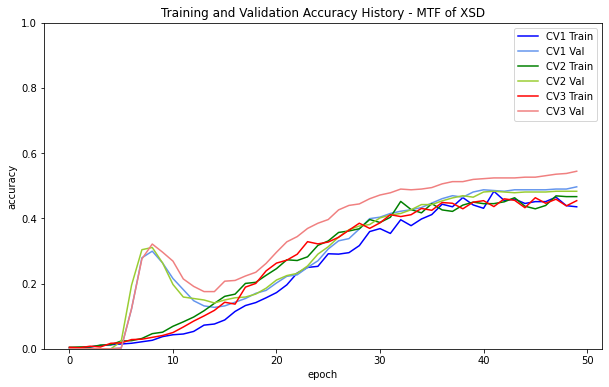

In [ ]:
# plot best history 
x=np.arange(best_params_mtf["epochs"])
plt.figure(figsize=(10, 6))

plt.plot(x, history_mtf[best_key_mtf][0]["accuracy"], color="b")
plt.plot(x, history_mtf[best_key_mtf][0]["val_accuracy"], color="cornflowerblue")
plt.plot(x, history_mtf[best_key_mtf][1]["accuracy"], color="g")
plt.plot(x, history_mtf[best_key_mtf][1]["val_accuracy"], "yellowgreen")
plt.plot(x, history_mtf[best_key_mtf][2]["accuracy"], color="r")
plt.plot(x, history_mtf[best_key_mtf][2]["val_accuracy"], color="lightcoral")
plt.legend(["CV1 Train", "CV1 Val", "CV2 Train", "CV2 Val", "CV3 Train", "CV3 Val"], loc="upper right")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Training and Validation Accuracy History - MTF of XSD")
plt.ylim(0,1)
plt.show()

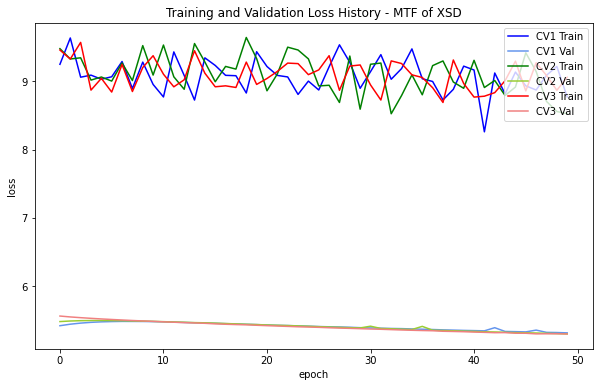

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(x, history_mtf[best_key_mtf][0]["loss"], color="b")
plt.plot(x, history_mtf[best_key_mtf][0]["val_loss"], color="cornflowerblue")
plt.plot(x, history_mtf[best_key_mtf][1]["loss"], color="g")
plt.plot(x, history_mtf[best_key_mtf][1]["val_loss"], "yellowgreen")
plt.plot(x, history_mtf[best_key_mtf][2]["loss"], color="r")
plt.plot(x, history_mtf[best_key_mtf][2]["val_loss"], color="lightcoral")
plt.legend(["CV1 Train", "CV1 Val", "CV2 Train", "CV2 Val", "CV3 Train", "CV3 Val"], loc="upper right")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training and Validation Loss History - MTF of XSD")
plt.show()

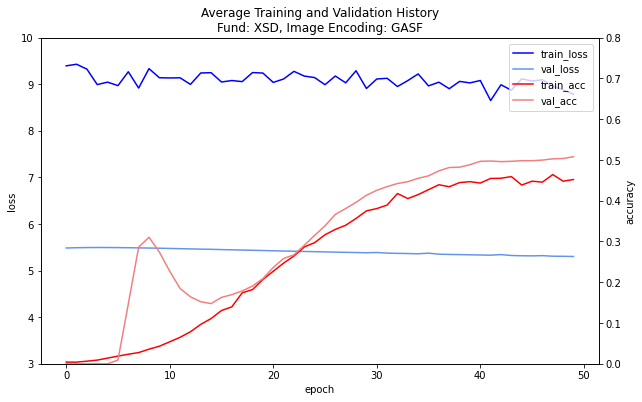

<Figure size 432x288 with 0 Axes>

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(x, avg_cv_results_mtf[best_key_mtf]["loss"], color="b", label="train_loss")
ax.plot(x, avg_cv_results_mtf[best_key_mtf]["val_loss"], color="cornflowerblue", label="val_loss")# set x-axis label
ax.set_xlabel("epoch",fontsize=10)
ax.set_ylabel("loss",fontsize=10)
ax.set_ylim((3,10))

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(x, avg_cv_results_mtf[best_key_mtf]["accuracy"], color="r", label="train_acc")
ax2.plot(x, avg_cv_results_mtf[best_key_mtf]["val_accuracy"], color="lightcoral", label="val_acc")
ax2.set_ylim((0,0.8))
ax2.set_ylabel("accuracy",fontsize=10)
fig.legend(loc='upper right', bbox_to_anchor=(0.33, 0.34, 0.5, 0.5))
plt.title("Average Training and Validation History\nFund: XSD, Image Encoding: GASF")
plt.show()

plt.savefig("/content/drive/MyDrive/Thesis/results/history_xsd_mtf")

In [ ]:
val_X=1
val_y=2

best_model_mtf =  build_model2D_basic(X_train_mtf, y_train, val_X, val_y,
                         kernel=best_params_mtf["kernel"],
                        activation=best_params_mtf["activation"],
                        padding=best_params_mtf["padding"], 
                        pooling=best_params_mtf["pooling"], 
                        batch_normalization=best_params_mtf["batch_normalization"], 
                        drop_out=best_params_mtf["drop_out"],
                        optimizer=best_params_mtf["optimizer"],
                        learning_rate=best_params_mtf["learning_rate"], 
                        epochs=best_params_mtf["epochs"],  
                        batch_size=best_params_mtf["batch_size"], 
                        class_weight=best_params_mtf["class_weight"],
                        val_data=False)

In [ ]:
tf.keras.models.save_model(best_model_mtf, filepath="/content/drive/MyDrive/Thesis/results/BESTMODEL_XSD_MTF")
# best_model_mtf = load_model("//content/drive/MyDrive/Thesis/results/BESTMODEL_XSD_MTF")

In [ ]:
_, train_acc_ = best_model_mtf.evaluate(X_train_mtf, y_train, verbose=0)
_, test_acc = best_model_mtf.evaluate(X_test_mtf, y_test, verbose=0)

print("train_acc",train_acc_)
print("\ntest_acc",test_acc)

predict_train = best_model_mtf.predict(X_train_mtf)
predictions_train=np.argmax(predict_train,axis=1)

predict_test = best_model_mtf.predict(X_test_mtf)
predictions_test=np.argmax(predict_test,axis=1)

print("\nMacro Average Train",  round(f1_score(y_train,predictions_train, average="macro"),4))
print("Macro Average Test",  round(f1_score(y_test,predictions_test, average="macro"),4))

print("\nWeighted Average Train",  round(f1_score(y_train,predictions_train, average="weighted"),4))
print("Weighted Average Test",  round(f1_score(y_test,predictions_test, average="weighted"),4))

print("\nClassification Report Train Set")
print(classification_report(y_train, predictions_train, digits=4))

print("\nClassification Report Test Set")
print(classification_report(y_test, predictions_test, digits=4))

train_acc 0.532667875289917

test_acc 0.48161765933036804

Macro Average Train 0.3854
Macro Average Test 0.2815

Weighted Average Train 0.455
Weighted Average Test 0.3687

Classification Report Train Set
              precision    recall  f1-score   support

           0     0.5000    0.1173    0.1901       554
           1     0.5358    0.9188    0.6769      1084
           2     0.5256    0.1996    0.2894       566

    accuracy                         0.5327      2204
   macro avg     0.5205    0.4119    0.3854      2204
weighted avg     0.5242    0.5327    0.4550      2204


Classification Report Test Set
              precision    recall  f1-score   support

           0     0.4583    0.0827    0.1401       133
           1     0.4980    0.9145    0.6448       269
           2     0.1923    0.0352    0.0595       142

    accuracy                         0.4816       544
   macro avg     0.3829    0.3441    0.2815       544
weighted avg     0.4085    0.4816    0.3687       544



In [ ]:
df_confusion = pd.crosstab(y_test, predictions_test, colnames=["prediction"], rownames=["true value"])
print(df_confusion)

prediction   0    1   2
true value             
0           11  118   4
1            6  246  17
2            7  130   5


In [ ]:
from financial_eval import financial_performance_model_short
predictions_train=predictions_train-1
financial_performance_model_short(data_copy[10:len(predictions_train)+10], predictions_train)

Day 0: purchase of 833.61 units for total of 9995 euros

Day 3:
Total sale:1000.33 units for total of 11258.72 euros
Closed long position: 833.61 units
New short position: 166.72 units

Day 17:
Short position closed: repurchase of 166.72 shares.
Long position built: 729.28 units. Total value: 9159.71 euros

Day 23:
Total sale:875.14 units for total of 10024.1 euros
Closed long position: 729.28 units
New short position: 145.86 units

Day 50:
Short position closed: repurchase of 145.86 shares.
Long position built: 586.53 units. Total value: 8023.74 euros

Day 92:
Total sale:703.84 units for total of 12206.62 euros
Closed long position: 586.53 units
New short position: 117.31 units

Day 120:
Short position closed: repurchase of 117.31 shares.
Long position built: 620.39 units. Total value: 10261.32 euros

Day 136:
Total sale:744.47 units for total of 14474.94 euros
Closed long position: 620.39 units
New short position: 124.08 units

Day 143:
Short position closed: repurchase of 124.08 sha

In [ ]:
from financial_eval import financial_performance_model_short
predictions_test=predictions_test-1
financial_performance_model_short(data_copy[-len(predictions_test):], predictions_test)

Day 0: purchase of 142.12 units for total of 9995 euros

Day 7:
Total sale:170.54 units for total of 12377.91 euros
Closed long position: 142.12 units
New short position: 28.42 units

Day 10:
Short position closed: repurchase of 28.42 shares.
Long position built: 145.55 units. Total value: 10351.68 euros

Day 23:
Total sale:174.66 units for total of 11960.96 euros
Closed long position: 145.55 units
New short position: 29.11 units

Day 47:
Short position closed: repurchase of 29.11 shares.
Long position built: 135.05 units. Total value: 9835.88 euros

Day 81:
Total sale:162.06 units for total of 11378.09 euros
Closed long position: 135.05 units
New short position: 27.01 units

Day 121:
Short position closed: repurchase of 27.01 shares.
Long position built: 139.51 units. Total value: 9528.31 euros

Day 131:
Total sale:167.41 units for total of 12071.96 euros
Closed long position: 139.51 units
New short position: 27.9 units

Day 164:
Short position closed: repurchase of 27.9 shares.
Long 

# Random Simulation

In [ ]:
y_test=y_test+1
import sklearn
unique, counts = np.unique(y_train, return_counts=True)
counts=counts/counts.sum()

accuracy_list = []
f1_list_weighted = []
f1_list_macro = []

for i in range(10000):
  y_random = np.random.choice([0,1,2] , size= len(y_test), p= counts)
  accuracy = sklearn.metrics.accuracy_score(y_test, y_random)
  f1_score_weighted = sklearn.metrics.f1_score(y_test, y_random, average='weighted')
  f1_score_macro = sklearn.metrics.f1_score(y_test, y_random, average='macro')
  accuracy_list.append(accuracy)
  f1_list_weighted.append(f1_score_weighted)
  f1_list_macro.append(f1_score_macro)
print(f"Average accuracy: {round(np.mean(accuracy_list),2)}")
print(f"Average F1-Score weighted: {round(np.mean(f1_list_weighted),2)}")
print(f"Average F1-Score macro: {round(np.mean(f1_list_macro),2)}")

Average accuracy: 0.37
Average F1-Score weighted: 0.37
Average F1-Score macro: 0.33
